In [44]:
%load_ext autoreload
%autoreload 2

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
from tqdm import tqdm
from scipy.spatial.distance import euclidean

# Configure logging to show debug messages only from our project code
# Set root logger to WARNING to suppress debug from other libraries
logging.getLogger().setLevel(logging.DEBUG)

# ignore debug messages from other libraries
logging.getLogger('matplotlib').setLevel(logging.WARNING)


# import the project root
sys.path.insert(0, '../..')
from src.covertree import CoverTree 
from src.dyadictree import DyadicTree
from src.dyadictreenode import DyadicTreeNode
from src.utils import *

from load_mnist import load_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# ========== NEW: Scikit-learn-like API Demo ==========

# Load fresh MNIST data for the demo
X_demo, original_shape_demo = load_dataset(flatten=True)

# Create a new CoverTree for clean demo
cover_tree_demo = CoverTree(X_demo, euclidean, leafsize=1)

# Create DyadicTree using NEW API (without fitting yet)
dyadic_sklearn = DyadicTree(
    cover_tree=cover_tree_demo,
    manifold_dims=0,      # Expected intrinsic dimension
    max_dim=X_demo.shape[-1],  # Maximum basis dimension  
    thresholds=0.2,       # Thresholds for basis construction
    precisions=1e-2,      # Precision parameters
    inverse=True          # Data in (n,d) format
)

# METHOD 1: Fit and transform separately (like sklearn.decomposition.PCA)
dyadic_sklearn.fit(X_demo)
coeffs_method1, leaf_indices_method1 = dyadic_sklearn.transform(X_demo)
X_recon_method1 = dyadic_sklearn.inverse_transform((coeffs_method1, leaf_indices_method1))

# Calculate reconstruction error
error_method1 = np.mean(np.linalg.norm(X_demo - X_recon_method1, axis=1))


DEBUG:root:Building tree at level 1, node indices: [5 8 6 4 2 7 1 9 3 0]
DEBUG:root:Updated tree height to 2
DEBUG:root:Processing internal node at level 1 with 8 children
DEBUG:root:Created child 1/8 at level 1
DEBUG:root:Building tree at level 2, node indices: [5]
DEBUG:root:Updated tree height to 3
DEBUG:root:Created leaf node at level 2 with indices: [5]
DEBUG:root:Created child 2/8 at level 1
DEBUG:root:Building tree at level 2, node indices: [8 6 4]
DEBUG:root:Processing internal node at level 2 with 3 children
DEBUG:root:Created child 1/3 at level 2
DEBUG:root:Building tree at level 3, node indices: [8]
DEBUG:root:Updated tree height to 4
DEBUG:root:Created leaf node at level 3 with indices: [8]
DEBUG:root:Created child 2/3 at level 2
DEBUG:root:Building tree at level 3, node indices: [6]
DEBUG:root:Created leaf node at level 3 with indices: [6]
DEBUG:root:Created child 3/3 at level 2
DEBUG:root:Building tree at level 3, node indices: [4]
DEBUG:root:Created leaf node at level 3 

info: making wavelets



4. Visualizing first 10 examples: Original vs Reconstructed


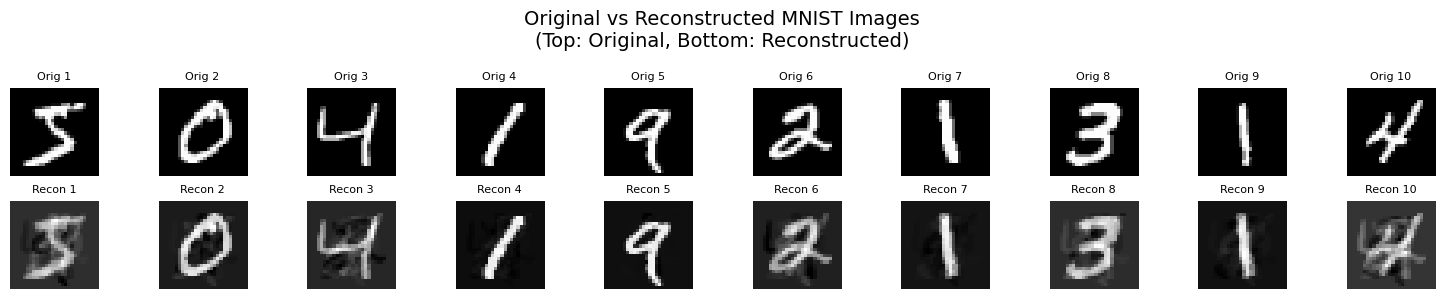

In [46]:
# ========== VISUALIZATION: Original vs Reconstructed Images ==========
print("\n4. Visualizing first 10 examples: Original vs Reconstructed")

# Reshape data back to image format (28x28 for MNIST)
X_demo_images = X_demo[:10].reshape(-1, 28, 28)
X_recon_images = X_recon_method1[:10].reshape(-1, 28, 28)

# Create subplot with 2 rows and 10 columns
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Original vs Reconstructed MNIST Images\n(Top: Original, Bottom: Reconstructed)', fontsize=14)

# Display original images in first row
for i in range(10):
    axes[0, i].imshow(X_demo_images[i], cmap='gray')
    axes[0, i].set_title(f'Orig {i+1}', fontsize=8)
    axes[0, i].axis('off')

# Display reconstructed images in second row
for i in range(10):
    axes[1, i].imshow(X_recon_images[i], cmap='gray')
    axes[1, i].set_title(f'Recon {i+1}', fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [47]:
coeffs_method1[0]


[array([[-3.3968937],
        [-2.8215175],
        [-2.7716575],
        [-0.768949 ],
        [ 1.1593664],
        [ 2.2342985]], dtype=float32),
 array([], shape=(0, 1), dtype=float64),
 array([], shape=(0, 1), dtype=float64)]

In [19]:
# dyadic_sklearn.fgwt(X_demo[8].reshape(1, -1))

In [20]:
# dummy = dyadic_sklearn.fgwt_all_node(X_demo)

In [21]:
# dummy, coeff_map = dyadic_sklearn.fgwt_all_node(X_demo)

In [22]:
# coeff_map

In [23]:
# dyadic_sklearn.fgwt(X_demo[9].reshape(1, -1))

In [24]:
# X_demo.shape

In [25]:
j = dyadic_sklearn.fgwt_batch(X_demo)

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 10 leaf nodes
DEBUG:root:Found 10 leaf nodes for batch processing
DEBUG:root:['(j=2, k=0)', '(j=3, k=0)', '(j=3, k=1)', '(j=2, k=3)', '(j=2, k=4)', '(j=2, k=5)', '(j=2, k=6)', '(j=2, k=7)', '(j=2, k=8)', '(j=2, k=9)']
DEBUG:root:Processed leaf (j=2, k=0)
DEBUG:root:Processed leaf (j=3, k=0)
DEBUG:root:Processed leaf (j=3, k=1)
DEBUG:root:Processed leaf (j=2, k=3)
DEBUG:root:Processed leaf (j=2, k=4)
DEBUG:root:Processed leaf (j=2, k=5)
DEBUG:root:Processed leaf (j=2, k=6)
DEBUG:root:Processed leaf (j=2, k=7)
DEBUG:root:Processed leaf (j=2, k=8)
DEBUG:root:Processed leaf (j=2, k=9)


In [26]:
j.shape

(10, 62)

In [27]:
# a, b = dyadic_sklearn.fgwt(X_demo)

In [28]:
# a, b = dyadic_sklearn.fgwt(X_demo)

In [29]:
# hat = dyadic_sklearn.inverse_transform((a, b))

In [30]:
feat = dyadic_sklearn.fgwt_batch(X_demo)

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 10 leaf nodes
DEBUG:root:Found 10 leaf nodes for batch processing
DEBUG:root:['(j=2, k=0)', '(j=3, k=0)', '(j=3, k=1)', '(j=2, k=3)', '(j=2, k=4)', '(j=2, k=5)', '(j=2, k=6)', '(j=2, k=7)', '(j=2, k=8)', '(j=2, k=9)']
DEBUG:root:Processed leaf (j=2, k=0)
DEBUG:root:Processed leaf (j=3, k=0)
DEBUG:root:Processed leaf (j=3, k=1)
DEBUG:root:Processed leaf (j=2, k=3)
DEBUG:root:Processed leaf (j=2, k=4)
DEBUG:root:Processed leaf (j=2, k=5)
DEBUG:root:Processed leaf (j=2, k=6)
DEBUG:root:Processed leaf (j=2, k=7)
DEBUG:root:Processed leaf (j=2, k=8)
DEBUG:root:Processed leaf (j=2, k=9)


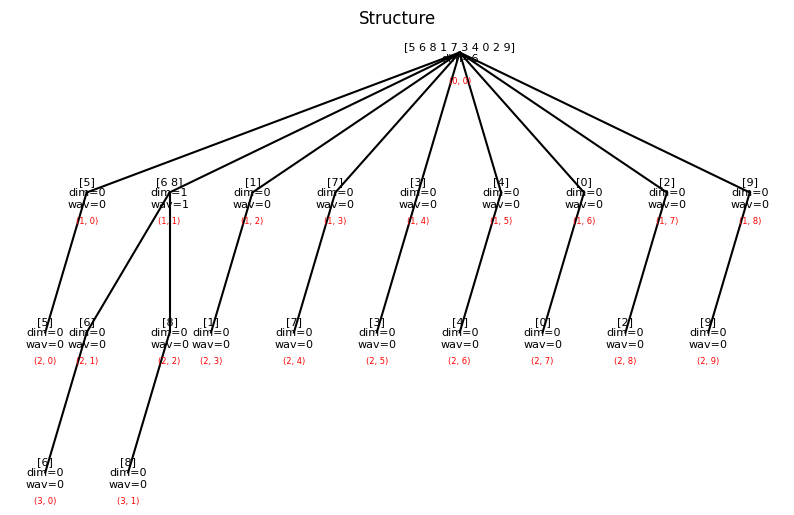

In [31]:
dyadic_sklearn.plot_tree(show_basis_dim=True)

In [32]:
inv, inv_each = dyadic_sklearn.igwt_batch(feat,  None, None)

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 10 leaf nodes
DEBUG:root:Found 10 leaf nodes for batch processing
DEBUG:root:['(j=2, k=0)', '(j=3, k=0)', '(j=3, k=1)', '(j=2, k=3)', '(j=2, k=4)', '(j=2, k=5)', '(j=2, k=6)', '(j=2, k=7)', '(j=2, k=8)', '(j=2, k=9)']
DEBUG:root:Processing leaf (j=2, k=0)
DEBUG:root:Multiplying jk (j=2, k=0),                with coeff from dimension 0 to 0
DEBUG:root:Multiplying node (j=1, k=0),                    with coeff from dimension 0 to 0
DEBUG:root:Multiplying root (j=0, k=0),                with coeff from dimension 0 to 6
DEBUG:root:Processing leaf (j=3, k=0)
DEBUG:root:Multiplying jk (j=3, k=0),                with coeff from dimension 6 to 6
DEBUG:root:Multiplying node (j=2, k=1),                    with coeff from dimension 6 to 6
DEBUG:root:Multiplying node (j=1, k=1),                    with coeff from dimension 6 to 7
DEBUG:root:Multiplying root (j=0, k=0),                with coeff from dimension 7 to 13
DEBUG:r

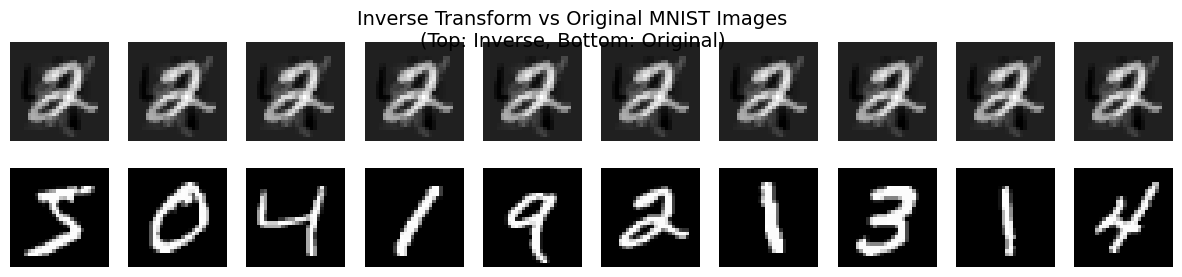

In [33]:
# visualize inv vs X_demo
inv_images = inv_each[0].reshape(-1, 28, 28)
X_demo_images = X_demo.reshape(-1, 28, 28)

# Create subplot with 2 rows and 10 columns
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Inverse Transform vs Original MNIST Images\n(Top: Inverse, Bottom: Original)', fontsize=14)

# Plot inverse images
for i in range(10):
    axes[0, i].imshow(inv_images[i], cmap='gray')
    axes[0, i].axis('off') 

# Plot original images
for i in range(10):
    axes[1, i].imshow(X_demo_images[i], cmap='gray')
    axes[1, i].axis('off')

plt.show()


In [34]:
np.allclose(inv[2], inv[0])

True